In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
import operator
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import settings

import Stemmer
import statsmodels.api as sm

/Users/owentemple/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def read_data():
    df = pd.read_excel(os.path.join('..',settings.PROCESSED_DIR, "all_with_liwc_segmented.xls"), encoding="ISO-8859-1")
    return df

In [3]:
df = read_data()

In [4]:
df['views'].describe()

count    2.406000e+03
mean     1.729881e+06
std      2.538130e+06
min      1.558950e+05
25%      7.902392e+05
50%      1.139610e+06
75%      1.707174e+06
max      4.722711e+07
Name: views, dtype: float64

In [6]:
views_median = df['views'].median()
views_upper_quantile = df['views'].quantile(.75)

In [8]:
df['views_label'] = np.where(df['views'] >= views_median, 1, 0)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
stemmer = SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [10]:
count_vect = StemmedCountVectorizer(analyzer="word", stop_words='english', min_df=2)
X_train_counts = count_vect.fit_transform(df['transcript'])
X_train_counts.shape

(2406, 20462)

In [11]:
sorted(count_vect.vocabulary_.items(), key=operator.itemgetter(1), reverse=True)

[('î¾', 20461),
 ('éte', 20460),
 ('èé', 20459),
 ('èâthank', 20458),
 ('èâso', 20457),
 ('èâ', 20456),
 ('ève', 20455),
 ('èt', 20454),
 ('ès', 20453),
 ('ère', 20452),
 ('èm', 20451),
 ('èll', 20450),
 ('èd', 20449),
 ('ås', 20448),
 ('åres', 20447),
 ('åre', 20446),
 ('åme', 20445),
 ('àvet', 20444),
 ('àveli', 20443),
 ('àve', 20442),
 ('zx81', 20441),
 ('zurich', 20440),
 ('zulu', 20439),
 ('zuckerman', 20438),
 ('zuckerberg', 20437),
 ('zuccotti', 20436),
 ('zopa', 20435),
 ('zooplankton', 20434),
 ('zoop', 20433),
 ('zoonot', 20432),
 ('zoom', 20431),
 ('zoolog', 20430),
 ('zoo', 20429),
 ('zone', 20428),
 ('zombi', 20427),
 ('zoe', 20426),
 ('zodiac', 20425),
 ('zipper', 20424),
 ('ziploc', 20423),
 ('ziplin', 20422),
 ('zipcar', 20421),
 ('zip', 20420),
 ('zine', 20419),
 ('zinc', 20418),
 ('zimbardo', 20417),
 ('zimbabwean', 20416),
 ('zimbabw', 20415),
 ('zillion', 20414),
 ('zilch', 20413),
 ('zika', 20412),
 ('zigzag', 20411),
 ('zig', 20410),
 ('zheng', 20409),
 ('zf', 20

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2406, 20462)

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, df['views_label'])

In [15]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)

In [16]:
predicted = clf.predict(X_test)
np.mean(predicted == y_test)

0.64119601328903653

In [17]:
clf.score(X_test, y_test)

0.64119601328903653

Classification accuracy is 64%

Null accuracy: accuracy that could be achieved by always predicting the most frequent class


In [18]:
# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
max(y_test.mean(), 1 - y_test.mean())

0.5232558139534884

This means that a dumb model that always predicts 0 would be right 52% of the time

This shows how classification accuracy is fairly good as 12% higher than a dumb model
It's a good way to know the minimum we should achieve with our models

In [32]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

standard_confusion_matrix(y_test, predicted)

array([[192, 108],
       [113, 189]])

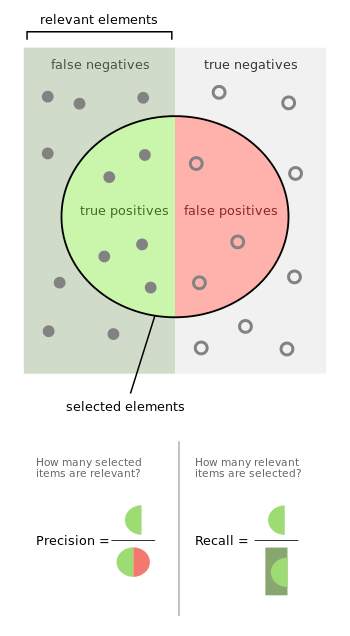

In [19]:
recall = recall_score(y_test, predicted)
recall

0.580952380952381

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [20]:
precision = precision_score(y_test, predicted)
precision

0.6853932584269663

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

In [21]:
F1 = 2 * (precision * recall) / (precision + recall)
F1

0.6288659793814434

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

In [22]:
def show_most_informative_features(vectorizer, clf, n=100):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [23]:
show_most_informative_features(count_vect,clf)

	-10.3712	0001           		-6.5935	peopl          
	-10.3712	09             		-6.6106	like           
	-10.3712	113            		-6.8329	just           
	-10.3712	117            		-6.8875	thing          
	-10.3712	122            		-6.8967	think          
	-10.3712	123            		-6.9715	know           
	-10.3712	125th          		-6.9978	time           
	-10.3712	127            		-7.0183	go             
	-10.3712	1298           		-7.0392	year           
	-10.3712	138            		-7.0769	want           
	-10.3712	1450           		-7.1295	look           
	-10.3712	1491           		-7.1480	realli         
	-10.3712	152            		-7.1702	make           
	-10.3712	153            		-7.1845	don            
	-10.3712	1750           		-7.1888	ve             
	-10.3712	1771           		-7.2091	way            
	-10.3712	1772           		-7.2134	work           
	-10.3712	1775           		-7.2136	world          
	-10.3712	1780s          		-7.2357	say            
	-10.3712	1788           		-7.2